# HAL Benchmark Results - Accuracy and Cost Barplots


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
import matplotlib.colors as mcolors
import seaborn as sns
import colorsys

from matplotlib_inline.backend_inline import set_matplotlib_formats
from matplotlib.ticker import PercentFormatter, MultipleLocator
from matplotlib.patches import Patch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, HPacker, AnchoredOffsetbox
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
from pathlib import Path
import os

# Add the src directory to Python path
src_path = Path('../src').resolve()
sys.path.insert(0, str(src_path))

# Always change to the quantitative directory
notebook_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
quantitative_dir = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
os.chdir(quantitative_dir)

# Now import and use the dataloader
from dataloader import load_most_recent_df

In [17]:
# Load the processed data
most_recent_df = load_most_recent_df()
print(f"Loaded dataset with {len(most_recent_df)} rows and {len(most_recent_df.columns)} columns")

# Filter out the runs where agent_scaffold contains "Generalist Agent"
filtered_df = most_recent_df[~most_recent_df['agent_scaffold'].str.contains('Generalist Agent', na=False)].copy()
print(f"Filtered dataset from {len(most_recent_df)} to {len(filtered_df)} rows (removed Generalist Agent runs)")

Looking for DB files in: /Users/peterkirgis/Documents/hal-paper-analysis/quantitative/hal-frontend/preprocessed_traces
Found 11 database files:
  - swebench_verified_mini.db
  - scicode.db
  - colbench_frontend_design.db
  - corebench_hard.db
  - usaco.db
  - taubench_airline.db
  - assistantbench.db
  - online_mind2web.db
  - scienceagentbench.db
  - colbench_backend_programming.db
  - gaia.db

Loading database: swebench_verified_mini

Tables in swebench_verified_mini.db: ['parsed_results', 'preprocessed_traces', 'token_usage']
  - parsed_results: 25 rows, 47 columns
  - preprocessed_traces: 25 rows, 5 columns
  - token_usage: 26 rows, 12 columns

Loading database: scicode

Tables in scicode.db: ['parsed_results', 'preprocessed_traces', 'token_usage']
  - parsed_results: 30 rows, 47 columns
  - preprocessed_traces: 30 rows, 5 columns
  - token_usage: 30 rows, 12 columns

Loading database: colbench_frontend_design

Tables in colbench_frontend_design.db: ['parsed_results', 'preprocessed

## Multi-Benchmark Faceted Plot

Create a single plot with all benchmarks as subplots, limited to specific models.

In [18]:
# Configure matplotlib for better quality plots with Inter font
import matplotlib.font_manager as fm
from pathlib import Path
mpl.rcParams.update({
    "font.family": "Inter",
    "font.weight": 400,
})

## Benchmark Configuration

Edit the benchmark configurations below to customize the plots. Each benchmark has its own settings for titles, subtitles, filtering, and special formatting.

In [20]:
# ═══════════════════════════════════════════════════════════════════
# BENCHMARK CONFIGURATIONS - Edit these to customize plots
# ═══════════════════════════════════════════════════════════════════

BENCHMARK_CONFIGS = {
    "CoreBench (Hard)": {
        "title": "Holistic Agent Leaderboard (HAL) – CoreBench (Hard)",
        "subtitle": "To solve a CORE-Bench task, agents need to reproduce the results of scientific papers using code and data from the paper.",
        "footer_note": "All models are evaluated using the CORE-Agent scaffold. Results are live and pending validation. \nSee evaluations of 171 agents across 8 benchmarks at hal.cs.princeton.edu.",
        "extra_queries": [],  # Additional pandas queries to filter data
        "extra_data": None,  # Function to add extra data rows
        "y_limit": 1.05,
        "y_tick_interval": 0.25,
        "bottom_margin": 0.3,
        "logo_height": 20,
        "label_positioning": "normal"  # "normal" or "compact"
    },
    
    "AssistantBench": {
        "title": "Holistic Agent Leaderboard (HAL) – AssistantBench", 
        "subtitle": "AssistantBench evaluates the ability of AI agents to solve realistic and time-consuming tasks on the web.",
        "footer_note": "All models are evaluated using a Browser-Use agent scaffold. Results are live and pending validation. \nHAL evaluations on AssistantBench utilize the publicly available 33 question validation set on HuggingFace. \nSee evaluations of 171 agents across 8 benchmarks at hal.cs.princeton.edu.",
        "extra_queries": ["~model.str.contains('R1', case=False)"],
        "extra_data": None,
        "y_limit": 1.05,
        "y_tick_interval": 0.25,
        "bottom_margin": 0.35,
        "logo_height": 28,
        "label_positioning": "compact"
    },
    
    "SciCode": {
        "title": "Holistic Agent Leaderboard (HAL) – SciCode",
        "subtitle": "SciCode evaluates the ability of AI agents to solve realistic scientific research and programming problems.",
        "footer_note": "All models are evaluated using a smolagents tool-calling scaffold. Results are live and pending validation. \nSee evaluations of 171 agents across 8 benchmarks at hal.cs.princeton.edu.",
        "extra_queries": ["~agent_name.str.contains('Generalist|Zero', case=False)"],
        "extra_data": lambda: pd.DataFrame({
            'model': ['Claude-4.1 Opus High'],
            'accuracy': [0.076923],
            'total_cost': [507.732270],
            'bench_label': ['SciCode'],
            'task_type': ['Code Generation']
        }),
        "y_limit": 0.25,
        "y_tick_interval": 0.05,
        "bottom_margin": 0.35,
        "logo_height": 28,
        "label_positioning": "compact",
        "logo_offset": 0.03
    },
    
    "TauBench – Airline": {
        "title": "Holistic Agent Leaderboard (HAL) – TauBench (Airline)",
        "subtitle": "TauBench asks agents to address customer queries for airline bookings and take the correct action in response.",
        "footer_note": "All models are evaluated using a few-shot agent scaffold. Results are live and pending validation. \nSee evaluations of 171 agents across 8 benchmarks at hal.cs.princeton.edu.",
        "extra_queries": [],
        "extra_data": None,
        "y_limit": 1.05,
        "y_tick_interval": 0.25,
        "bottom_margin": 0.3,
        "logo_height": 20,
        "label_positioning": "normal",
        "model_replacements": {
            "Claude Opus 4.1": "Claude-4.1 Opus",
            "Claude Opus 4.1 High": "Claude-4.1 Opus High",
            "Claude Opus 4": "Claude-4 Opus", 
            "Claude Opus 4 High": "Claude-4 Opus High"
        }
    },
    
    "SWE-bench Verified (Mini)": {
        "title": "Holistic Agent Leaderboard (HAL) – SWE-bench Verified (Mini)",
        "subtitle": "Swe-bench asks agents to solve software engineering problems drawn from real GitHub repositories.",
        "footer_note": "All models are evaluated using a SWE-Agent scaffold. Results are live and pending validation. \nSee evaluations of 171 agents across 8 benchmarks at hal.cs.princeton.edu.",
        "extra_queries": ["~model.str.contains('R1', case=False)"],
        "extra_data": None,
        "y_limit": 1.05,
        "y_tick_interval": 0.25,
        "bottom_margin": 0.3,
        "logo_height": 20,
        "label_positioning": "normal",
        "model_replacements": {
            "Claude Opus 4.1": "Claude-4.1 Opus",
            "Claude Opus 4.1 High": "Claude-4.1 Opus High",
            "Claude Opus 4": "Claude-4 Opus", 
            "Claude-4 Opus High": "Claude-4 Opus High"
        }
    },

    "ScienceAgentBench": {
    "title": "Holistic Agent Leaderboard (HAL) – ScienceAgentBench",
    "subtitle": "ScienceAgentBench asks agents to build Python programs for data-driven scientific discovery.",
    "footer_note": "All models are evaluated using a self-debugging agent scaffold. Results are live and pending validation. \nSee evaluations of 171 agents across 8 benchmarks at hal.cs.princeton.edu.",
    "extra_queries": [],
    "extra_data": None,
    "y_limit": 1.05,
    "y_tick_interval": 0.25,
    "bottom_margin": 0.3,
    "logo_height": 20,
    "label_positioning": "normal",
    "model_replacements": {
        "Claude Opus 4.1": "Claude-4.1 Opus",
        "Claude Opus 4.1 High": "Claude-4.1 Opus High",
        "Claude Opus 4": "Claude-4 Opus", 
        "Claude-4 Opus High": "Claude-4 Opus High"
        }
    },

    "GAIA": {
    "title": "Holistic Agent Leaderboard (HAL) – GAIA",
    "subtitle": "GAIA asks agents to answer real-world questions requiring deep internet research.",
    "footer_note": "All models are evaluated using smolagents open deep research. Results are live and pending validation. \nSee evaluations of 171 agents across 8 benchmarks at hal.cs.princeton.edu.",
    "extra_queries": [],
    "extra_data": None,
    "y_limit": 1.05,
    "y_tick_interval": 0.25,
    "bottom_margin": 0.3,
    "logo_height": 20,
    "label_positioning": "normal",
    "model_replacements": {
        "Claude Opus 4.1": "Claude-4.1 Opus",
        "Claude Opus 4.1 High": "Claude-4.1 Opus High",
        "Claude Opus 4": "Claude-4 Opus", 
        "Claude-4 Opus High": "Claude-4 Opus High"
        }
    },

    "Online Mind2Web": {
    "title": "Holistic Agent Leaderboard (HAL) – Online Mind2Web",
    "subtitle": "Online Mind2Web evaluates the ability of AI agents to navigate diverse web browsing tasks.",
    "footer_note": "All models are evaluated using a Browser-Use agent scaffold. Results are live and pending validation. \nSee evaluations of 171 agents across 8 benchmarks at hal.cs.princeton.edu.",
    "extra_queries": ["~agent_name.str.contains('SeeAct', case=False)"],
    "extra_data": None,
    "y_limit": 1.05,
    "y_tick_interval": 0.25,
    "bottom_margin": 0.3,
    "logo_height": 20,
    "label_positioning": "normal",
    "model_replacements": {
        "Claude Opus 4.1": "Claude-4.1 Opus",
        "Claude Opus 4.1 High": "Claude-4.1 Opus High",
        "Claude Opus 4": "Claude-4 Opus", 
        "Claude-4 Opus High": "Claude-4 Opus High"
        }
    },
}

## Plotting Functions

Reusable functions for creating the benchmark plots.

In [29]:
# ═══════════════════════════════════════════════════════════════════
# HELPER FUNCTIONS AND CONSTANTS
# ═══════════════════════════════════════════════════════════════════

# Brand colors and model mappings
BRAND_BASE = { 
    "OpenAI": "#10A37F", 
    "Anthropic": "#D4A27F",
    "DeepSeek": "#4D6BFE"
}

COMP_OF = {
    "o3 Medium":"OpenAI","o4-mini High":"OpenAI","o4-mini Low":"OpenAI",
    "GPT-4.1":"OpenAI","GPT-5 Medium":"OpenAI",
    "o3-mini High":"OpenAI","o3-mini Low":"OpenAI",
    "GPT-OSS-120B High":"OpenAI","GPT-OSS-120B":"OpenAI",
    "Claude-3.7 Sonnet":"Anthropic","Claude-3.7 Sonnet High":"Anthropic",
    "Claude-4 Sonnet":"Anthropic", "Claude-4 Sonnet High":"Anthropic",
    "Claude-4.1 Opus":"Anthropic", "Claude-4.1 Opus High":"Anthropic",
    "Claude-4 Opus":"Anthropic", "Claude-4 Opus High":"Anthropic",
    "DeepSeek R1":"DeepSeek","DeepSeek V3":"DeepSeek",
}

LOGO_PATHS = {
    "OpenAI":    str(quantitative_dir / "assets/openai_grey.png"),
    "Anthropic": str(quantitative_dir / "assets/anthropic_grey.png"),
    "DeepSeek":  str(quantitative_dir / "assets/deepseek_grey.png"),
}

def make_shades(base_hex, k, span=.20):
    """Create k shades of a base color."""
    r,g,b = mcolors.to_rgb(base_hex)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    hi    = min(1, l+span)
    return [mcolors.to_hex(colorsys.hls_to_rgb(h,L,s))
            for L in np.linspace(l,hi,k)]

def prepare_plot_data(benchmark_name, config, data_df):
    """Prepare and filter data for plotting a specific benchmark."""
    # Base query
    plot = (data_df
            .query("task_type != 'Other'")
            .query("model.str.contains('Claude|o4-mini|o3|GPT|DeepSeek', case=False)",
                   engine='python')
            .query("~agent_name.str.contains('Generalist', case=False)", engine='python')
            .query("bench_label == @benchmark_name"))
    
    # Apply extra queries from config
    for query in config.get("extra_queries", []):
        plot = plot.query(query, engine='python')
    
    # Apply model name replacements
    default_replacements = {
        "Claude Opus 4.1": "Claude-4.1 Opus", 
        "Claude Opus 4.1 High": "Claude-4.1 Opus High",
        "Claude Sonnet 4": "Claude-4 Sonnet",
        "Claude Sonnet 4 High": "Claude-4 Sonnet High"
    }
    model_replacements = {**default_replacements, **config.get("model_replacements", {})}
    plot['model'] = plot['model'].replace(model_replacements)
    
    # Add extra data if specified
    if config.get("extra_data") is not None:
        extra_df = config["extra_data"]()
        plot = pd.concat([plot, extra_df])
    
    if plot.empty:
        raise ValueError(f"No rows found for benchmark '{benchmark_name}'")
    
    return plot

def setup_colors(models):
    """Set up color scheme for models by company."""
    company_models, shade_of = {}, {}
    for m in models:
        company_models.setdefault(COMP_OF.get(m,"Other"), []).append(m)
    for comp, mlist in company_models.items():
        base = BRAND_BASE.get(comp, "#777777")
        for m,c in zip(sorted(mlist), make_shades(base, len(mlist))):
            shade_of[m] = c
    return shade_of

In [30]:
def add_labels_and_logos(ax, models, plot, shade_of, config):
    """Add accuracy/cost labels and company logos to bars."""
    inner_gap = .03
    group_w   = .90
    bar_w     = (group_w-(len(models)-1)*inner_gap)/len(models)
    offsets   = (np.arange(len(models))-(len(models)-1)/2) * (bar_w+inner_gap)
    
    logo_height = config.get("logo_height", 20)
    label_mode = config.get("label_positioning", "normal")
    logo_offset = config.get("logo_offset", 0.10)
    
    for off, m in zip(offsets, models):
        h  = plot.loc[plot['model']==m, 'accuracy'].iat[0]
        ct = plot.loc[plot['model']==m, 'total_cost'].iat[0]

        # Draw the bar
        ax.bar(off, h, width=bar_w,
               color=shade_of[m], edgecolor='black', linewidth=.8)

        # Add labels based on positioning mode
        if label_mode == "compact":
            # Compact labeling for low bars
            LABEL_PAD = 0.008
            COST_PAD  = 0.008
            would_overlap = (h - COST_PAD - 0.02) <= 0
            
            if would_overlap:
                # Put accuracy and cost on same line
                ax.text(off, h + LABEL_PAD, f"{h:.0%}", ha='center', va='bottom',
                        fontsize=10, weight='bold')
                ax.annotate(f"(${ct:,.0f})", xy=(off, h + LABEL_PAD), xytext=(8, 0),
                           textcoords='offset points', ha='left', va='bottom',
                           fontsize=9, weight='normal')
            else:
                # Normal two-line arrangement
                ax.text(off, h + LABEL_PAD, f"{h:.0%}", ha='center', va='bottom',
                        fontsize=10, weight='bold')
                ax.text(off, h - COST_PAD, f"${ct:,.0f}", ha='center', va='top',
                        fontsize=9)
        else:
            # Normal labeling
            ax.text(off, h+.008, f"{h:.0%}", ha='center', va='bottom',
                    fontsize=10, weight='bold')
            ax.text(off, h-.01, f"${ct:,.0f}", ha='center', va='top', fontsize=8.5)

        # Add company logo
        comp = COMP_OF.get(m, "Other")
        logo_path = LOGO_PATHS.get(comp)
        if logo_path and os.path.exists(logo_path):
            img  = mpimg.imread(logo_path)
            zoom = logo_height / img.shape[0]
            ax.add_artist(AnnotationBbox(
                OffsetImage(img, zoom=zoom, resample=True),
                (off, h+logo_offset), frameon=False, box_alignment=(0.5,0)
            ))
    
    return offsets, bar_w

def style_axes(ax, offsets, bar_w, models, config):
    """Apply styling to the plot axes."""
    ax.set_xticks(offsets)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
    ax.set_ylim(0, config.get("y_limit", 1.05))
    ax.set_xlim(offsets.min()-bar_w/2-.05, offsets.max()+bar_w/2+.05)
    ax.yaxis.set_major_formatter(PercentFormatter(1,0))
    ax.yaxis.set_major_locator(MultipleLocator(config.get("y_tick_interval", 0.25)))
    
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    for spine in ('left', 'bottom'):
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('black')

    ax.tick_params(axis='y', which='major', color='black', width=1, length=4)
    ax.tick_params(axis='x', which='major', length=4, width=1, color='black', 
                   direction='out', bottom=True)
    ax.tick_params(axis='y', which='both', left=True, labelleft=True)
    ax.set_ylabel("Accuracy (%)", fontsize=12)

    # Bold GPT-5 Medium labels
    for lbl in ax.get_xticklabels():
        if lbl.get_text() == "GPT-5 Medium":
            lbl.set_fontweight('bold')

def add_titles_and_footer(fig, ax, config):
    """Add title, subtitle and footer to the figure."""
    RIGHT = 0.9
    bottom_margin = config.get("bottom_margin", 0.3)
    fig.subplots_adjust(bottom=bottom_margin)
    
    # Add title and subtitle
    fig.text(0.05, 0.97, config["title"], ha='left', va='top',
             fontsize=15, fontweight='bold')
    fig.text(0.05, 0.93, config["subtitle"], ha='left', va='top',
             fontsize=12, color='.35')
    
    # Footer setup
    FOOT_Y, FOOT_H = 0.03, 0.10
    LOGO_H_PX_FOOT, LOGO_SEP_PX = 28, 5
    footer_logo_paths = [
        str(quantitative_dir / "assets/HAL.png"),
        str(quantitative_dir / "hal-frontend/static/pli.png"),
        str(quantitative_dir / "hal-frontend/static/princeton.png"),
    ]

    icons, total_logo_px = [], 0
    for p in footer_logo_paths:
        if os.path.exists(p):
            img  = mpimg.imread(p)
            zoom = LOGO_H_PX_FOOT / img.shape[0]
            icons.append(OffsetImage(img, zoom=zoom, resample=True))
            total_logo_px += int(img.shape[1]*zoom) + LOGO_SEP_PX
    if icons:
        total_logo_px -= LOGO_SEP_PX

    fig_width_px = fig.get_size_inches()[0] * fig.dpi
    logo_w_frac  = total_logo_px / fig_width_px
    right_pad    = 1 - RIGHT
    note_w_frac  = 1 - logo_w_frac - 0.05 - right_pad

    ax_note = fig.add_axes([0.05, FOOT_Y, note_w_frac, FOOT_H])
    ax_note.axis('off')
    ax_note.text(0, 0, config["footer_note"], ha='left', va='bottom',
                 fontsize=10, color='.35', wrap=True, linespacing=1.25)

    if icons:
        fig.add_artist(AnchoredOffsetbox(
            loc='lower right',
            child=HPacker(children=icons, align='center', pad=0, sep=LOGO_SEP_PX),
            frameon=False, pad=0,
            bbox_to_anchor=(RIGHT, FOOT_Y),
            bbox_transform=fig.transFigure, borderpad=0
        ))

In [31]:
def create_benchmark_plot(benchmark_name, data_df, save_plots=True):
    """Create a complete benchmark plot with all styling and save it."""
    if benchmark_name not in BENCHMARK_CONFIGS:
        raise ValueError(f"No configuration found for benchmark '{benchmark_name}'")
    
    config = BENCHMARK_CONFIGS[benchmark_name]
    
    # Set global style
    mpl.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "font.size": 10,
        "hatch.linewidth": .8,
    })
    sns.set_theme(style="white", rc={"axes.grid": False})
    
    # Prepare data
    plot = prepare_plot_data(benchmark_name, config, data_df)
    models = plot.sort_values('accuracy', ascending=False)['model'].tolist()
    shade_of = setup_colors(models)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Add bars, labels and logos
    offsets, bar_w = add_labels_and_logos(ax, models, plot, shade_of, config)
    
    # Style the axes
    style_axes(ax, offsets, bar_w, models, config)
    
    # Add titles and footer
    add_titles_and_footer(fig, ax, config)
    
    plt.show()
    
    # Save plot
    if save_plots:
        output_path = str(quantitative_dir / "plots/")
        output_filename = f"hal_{benchmark_name.replace(' ', '_').lower().replace('–', '_')}.png"
        fig.savefig(os.path.join(output_path, output_filename), bbox_inches='tight', dpi=300)
        print(f"Saved plot: {output_filename}")
    
    return fig, ax

## Generate All Plots

Run this cell to generate all benchmark plots using the configurations above.


Creating plot for: CoreBench (Hard)


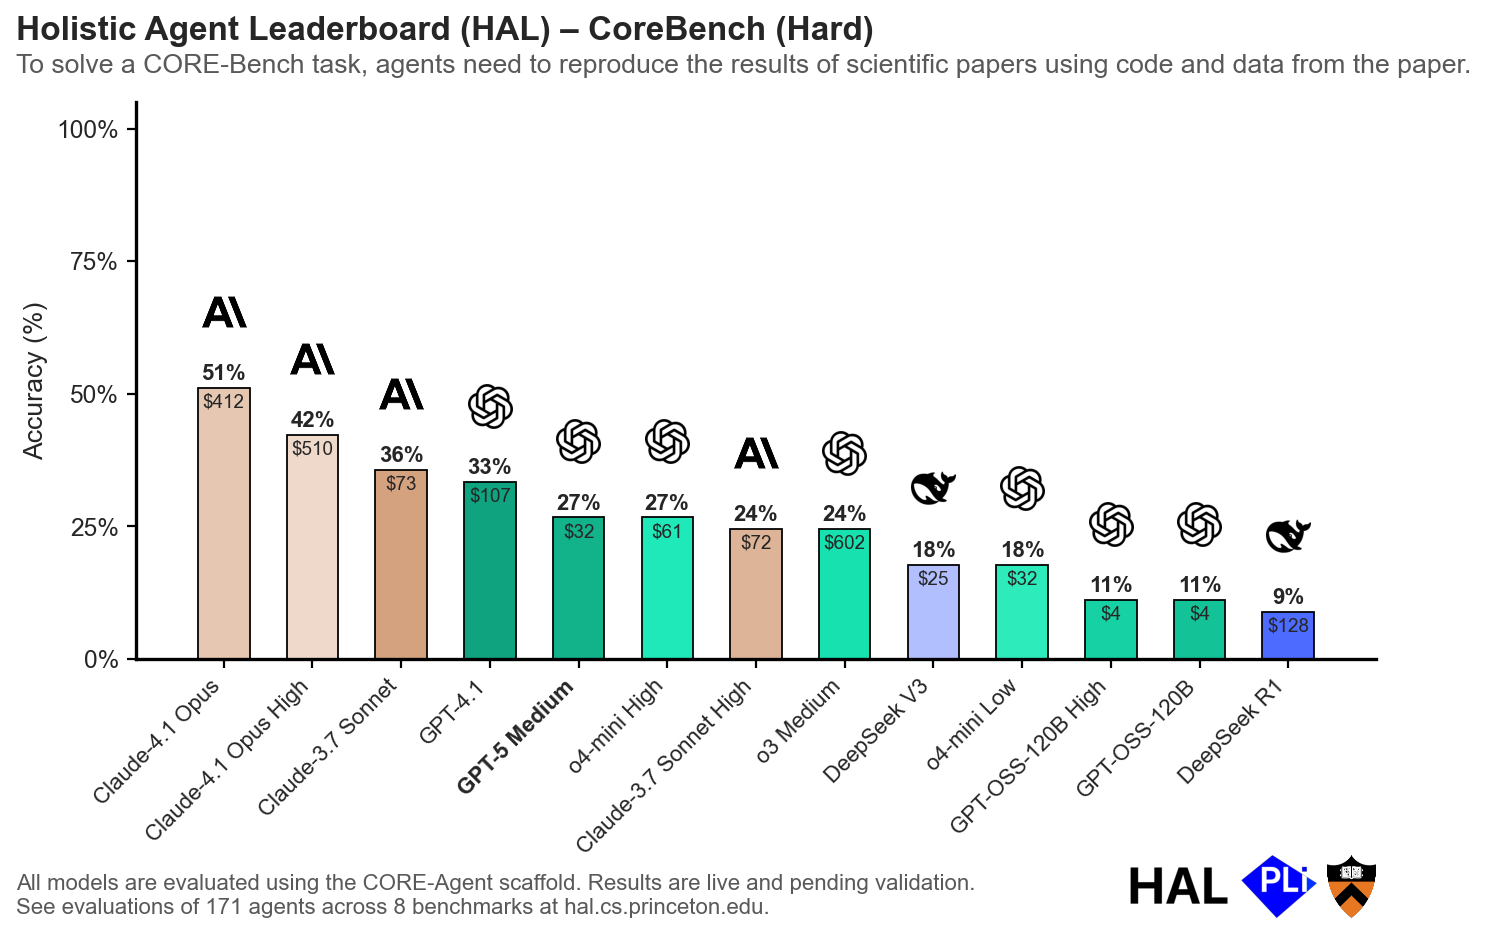

Saved plot: hal_corebench_(hard).png

Creating plot for: AssistantBench


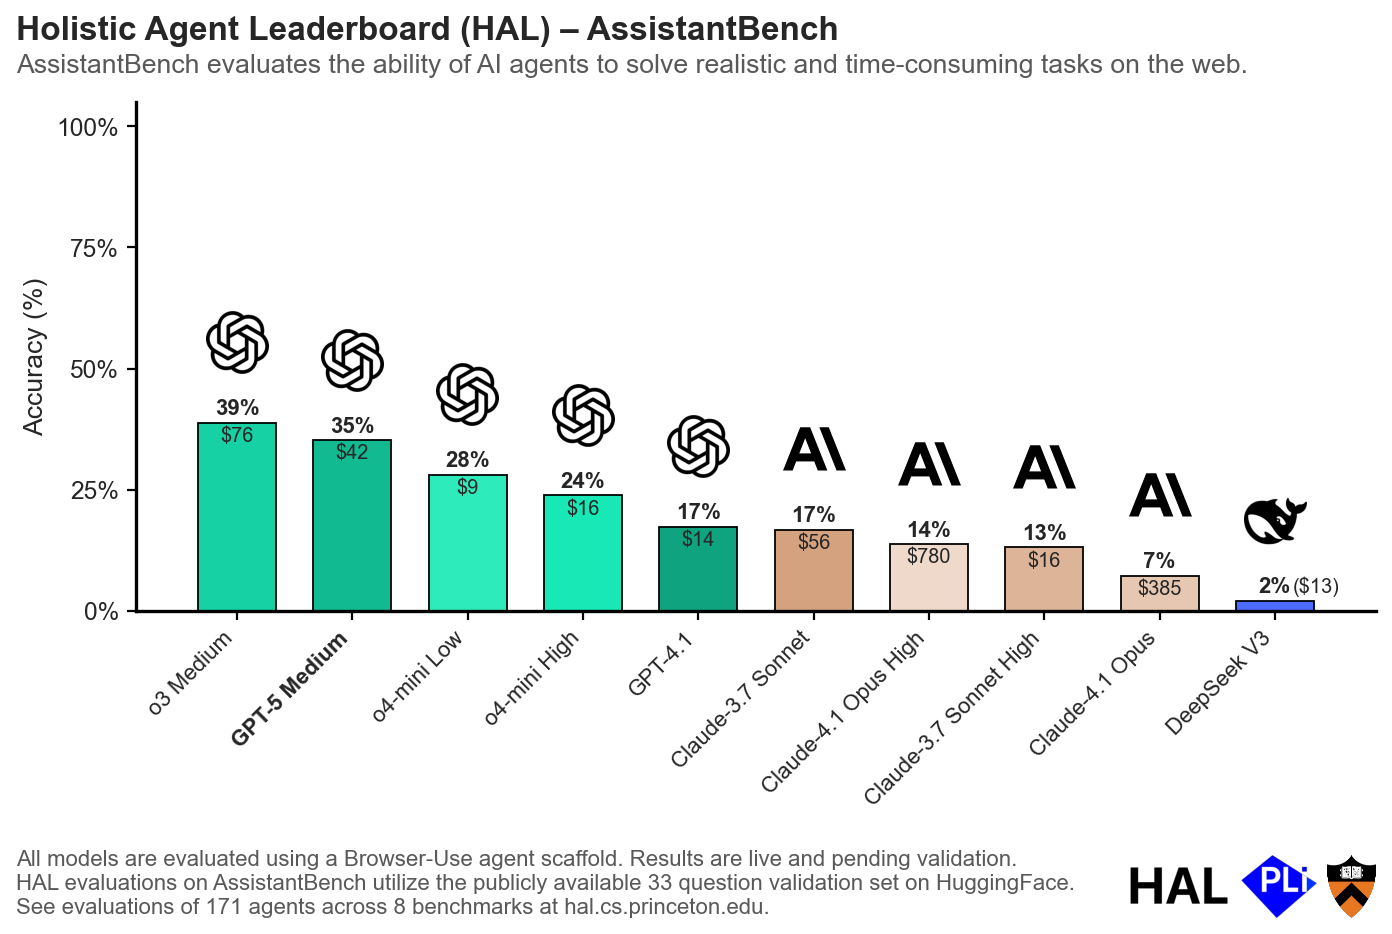

Saved plot: hal_assistantbench.png

Creating plot for: SciCode


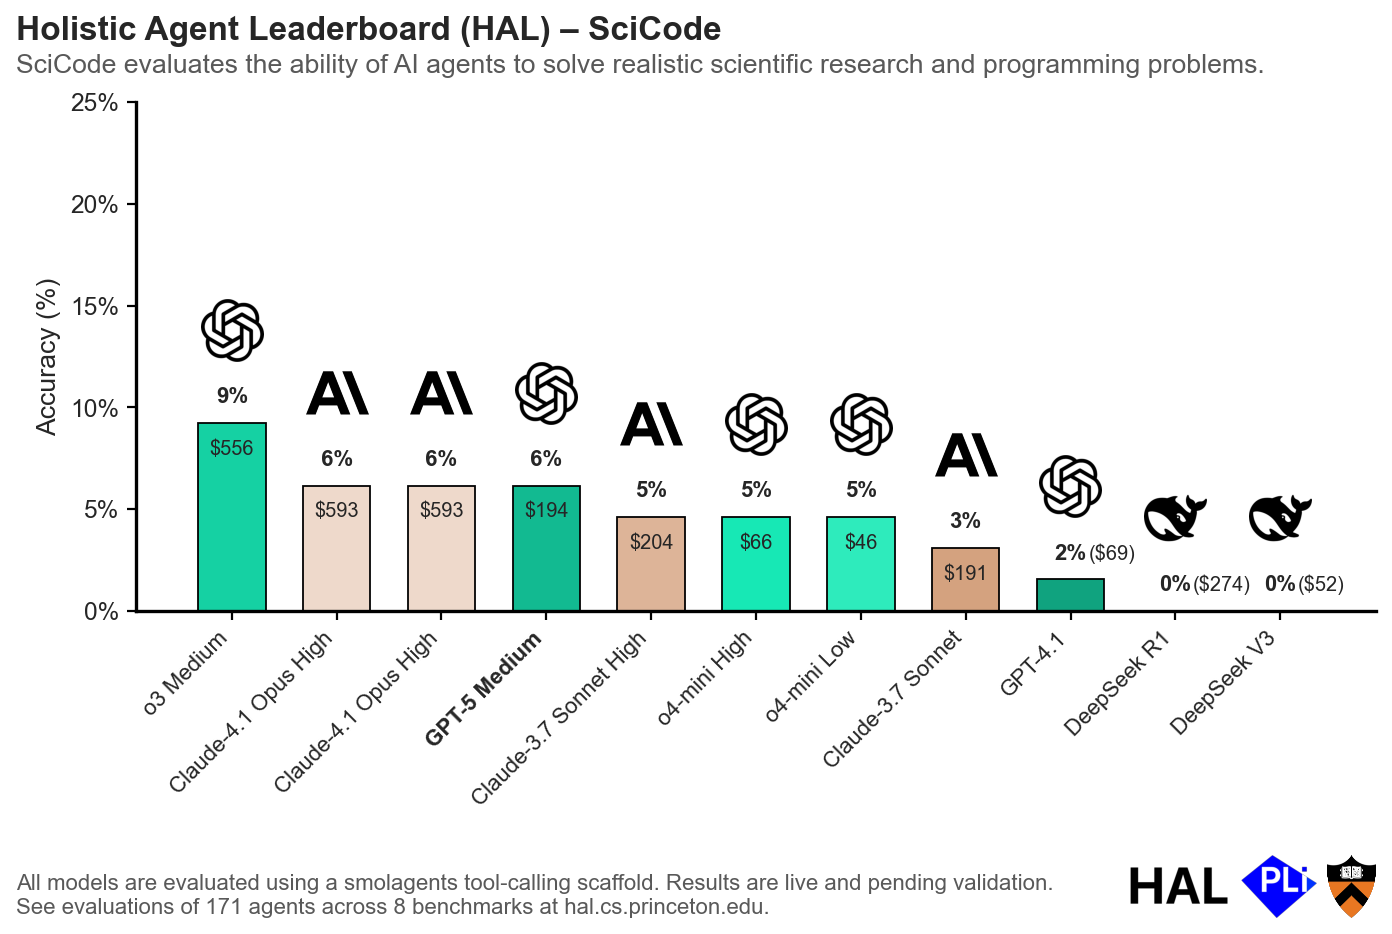

Saved plot: hal_scicode.png

Creating plot for: TauBench – Airline


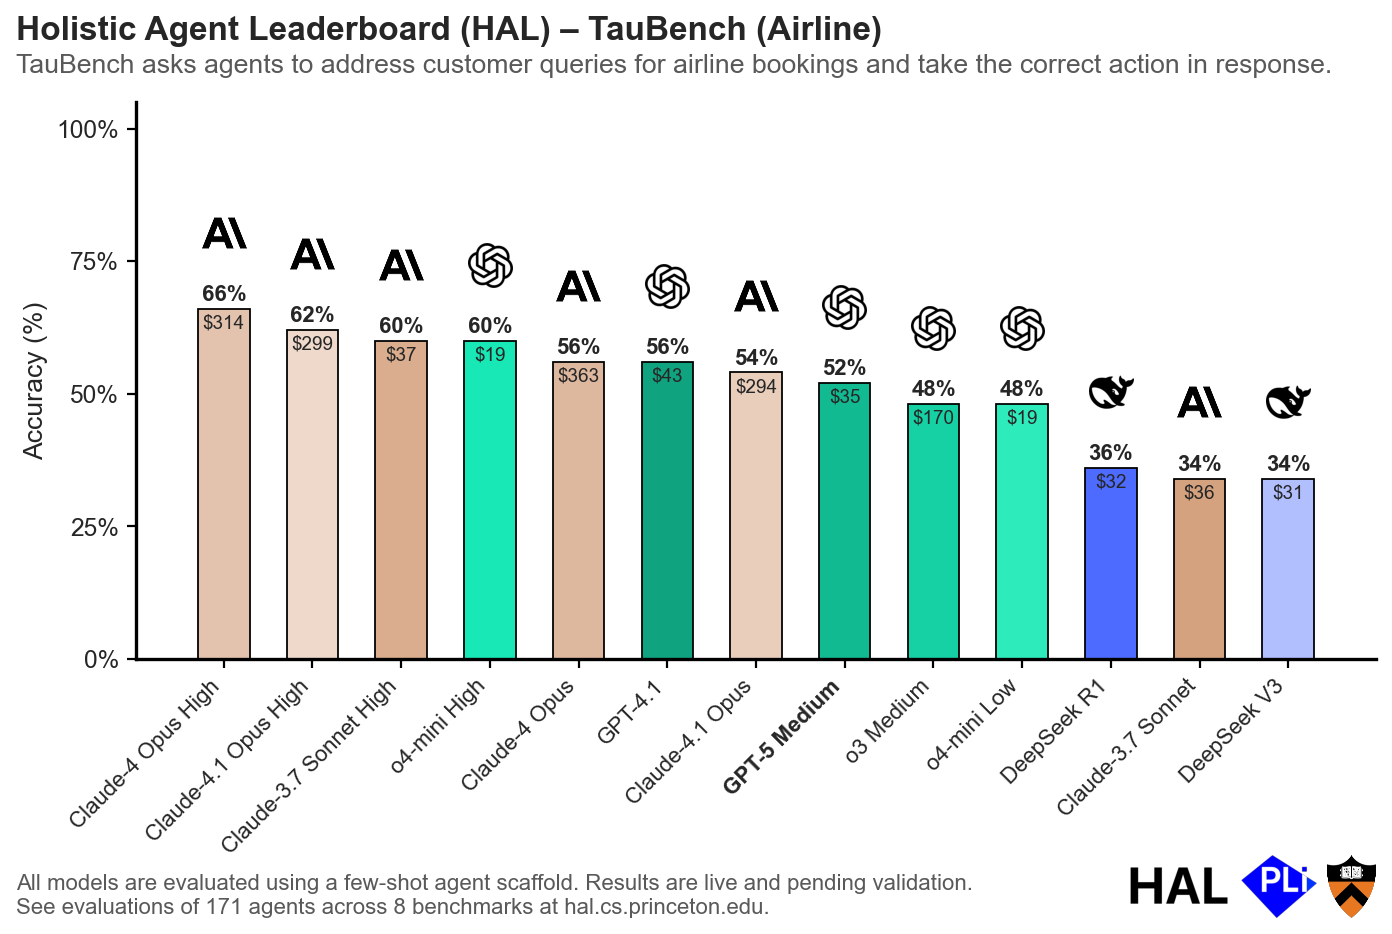

Saved plot: hal_taubench___airline.png

Creating plot for: SWE-bench Verified (Mini)


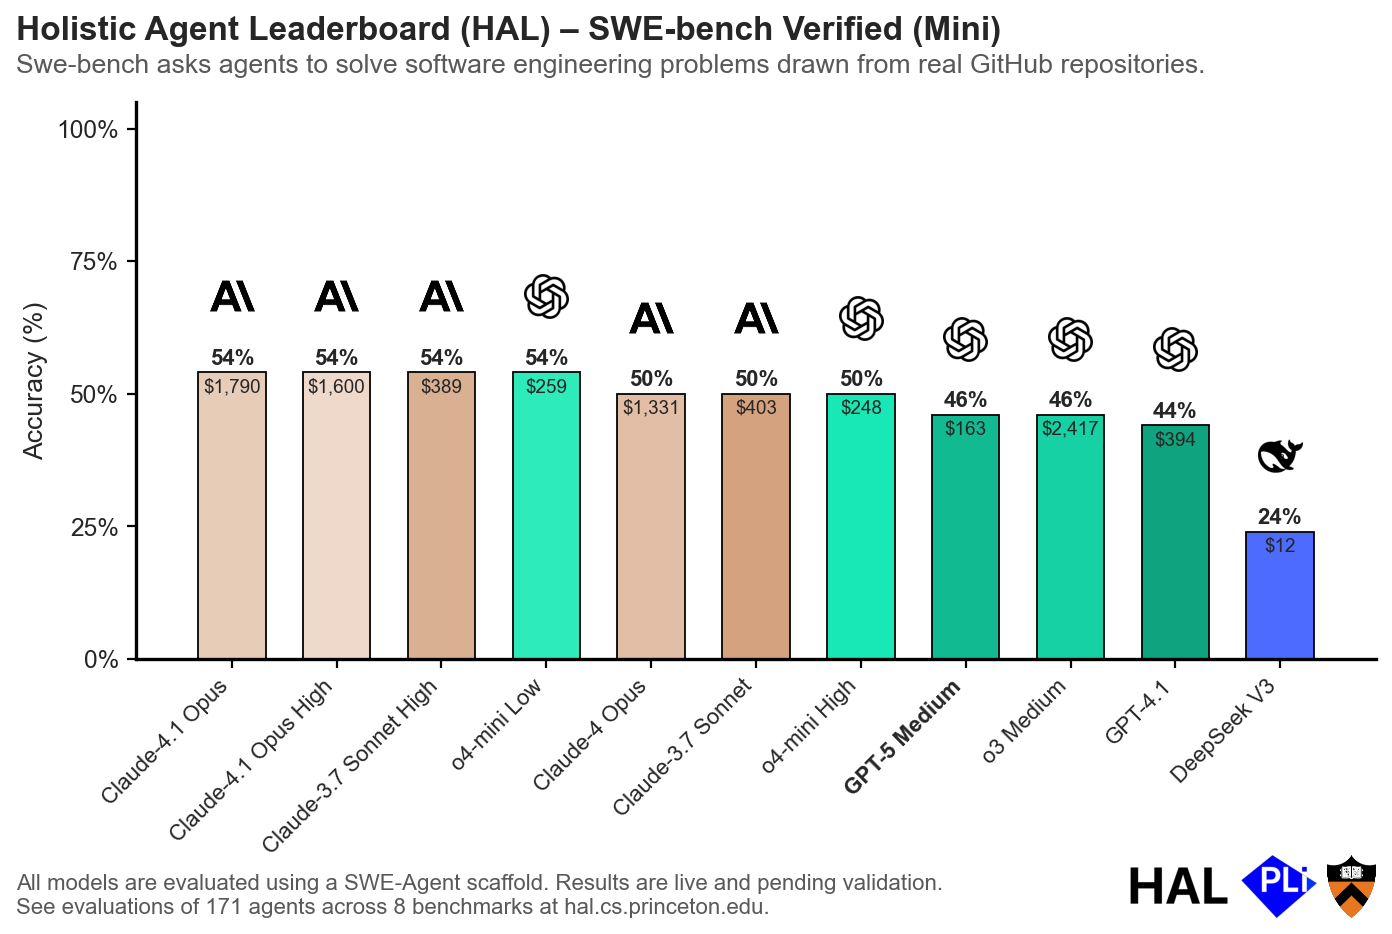

Saved plot: hal_swe-bench_verified_(mini).png

Creating plot for: ScienceAgentBench


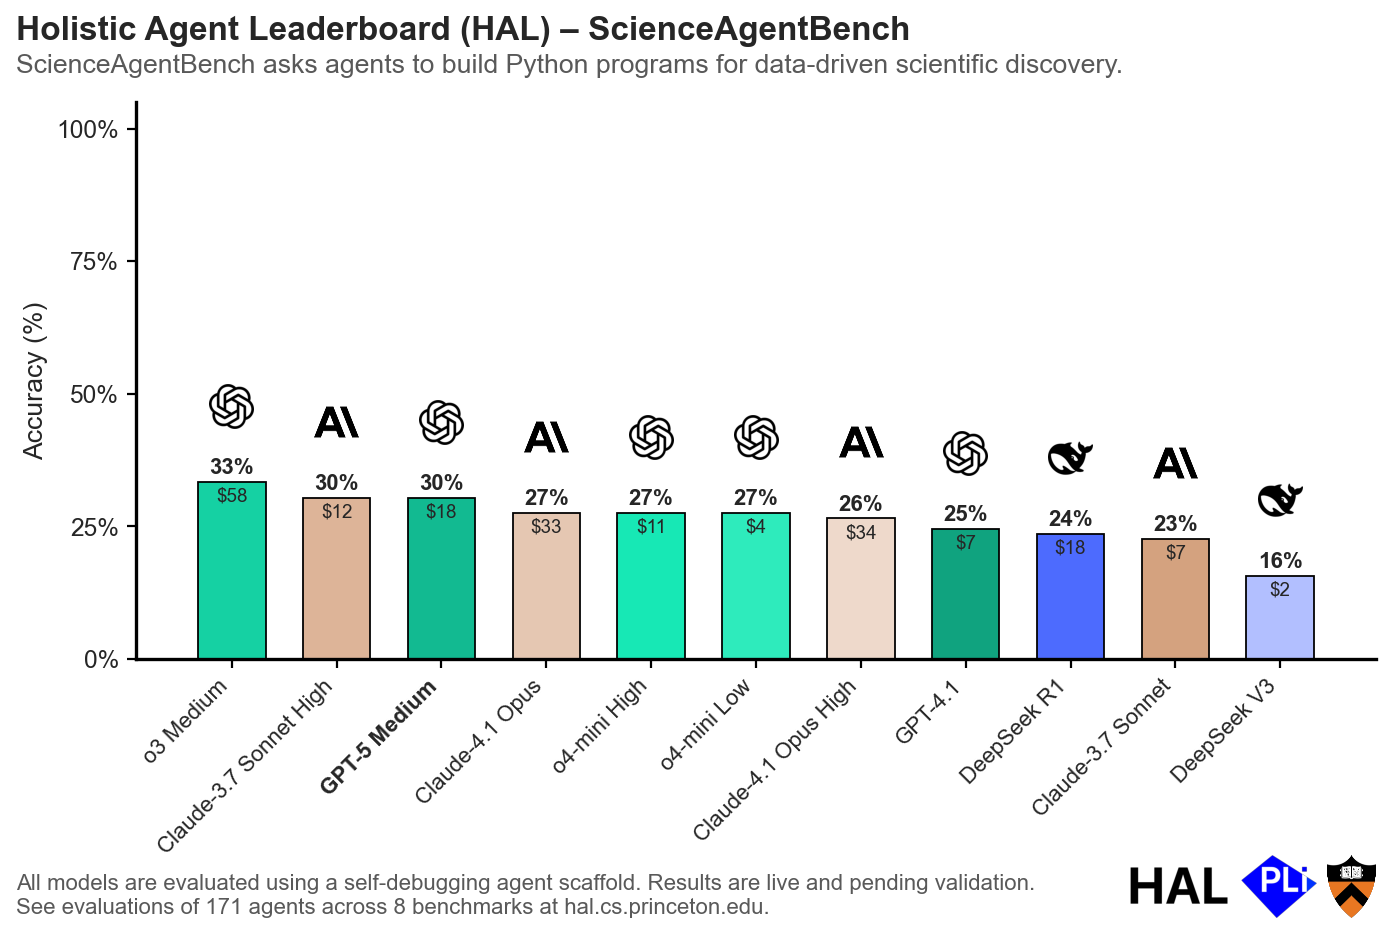

Saved plot: hal_scienceagentbench.png

Creating plot for: GAIA


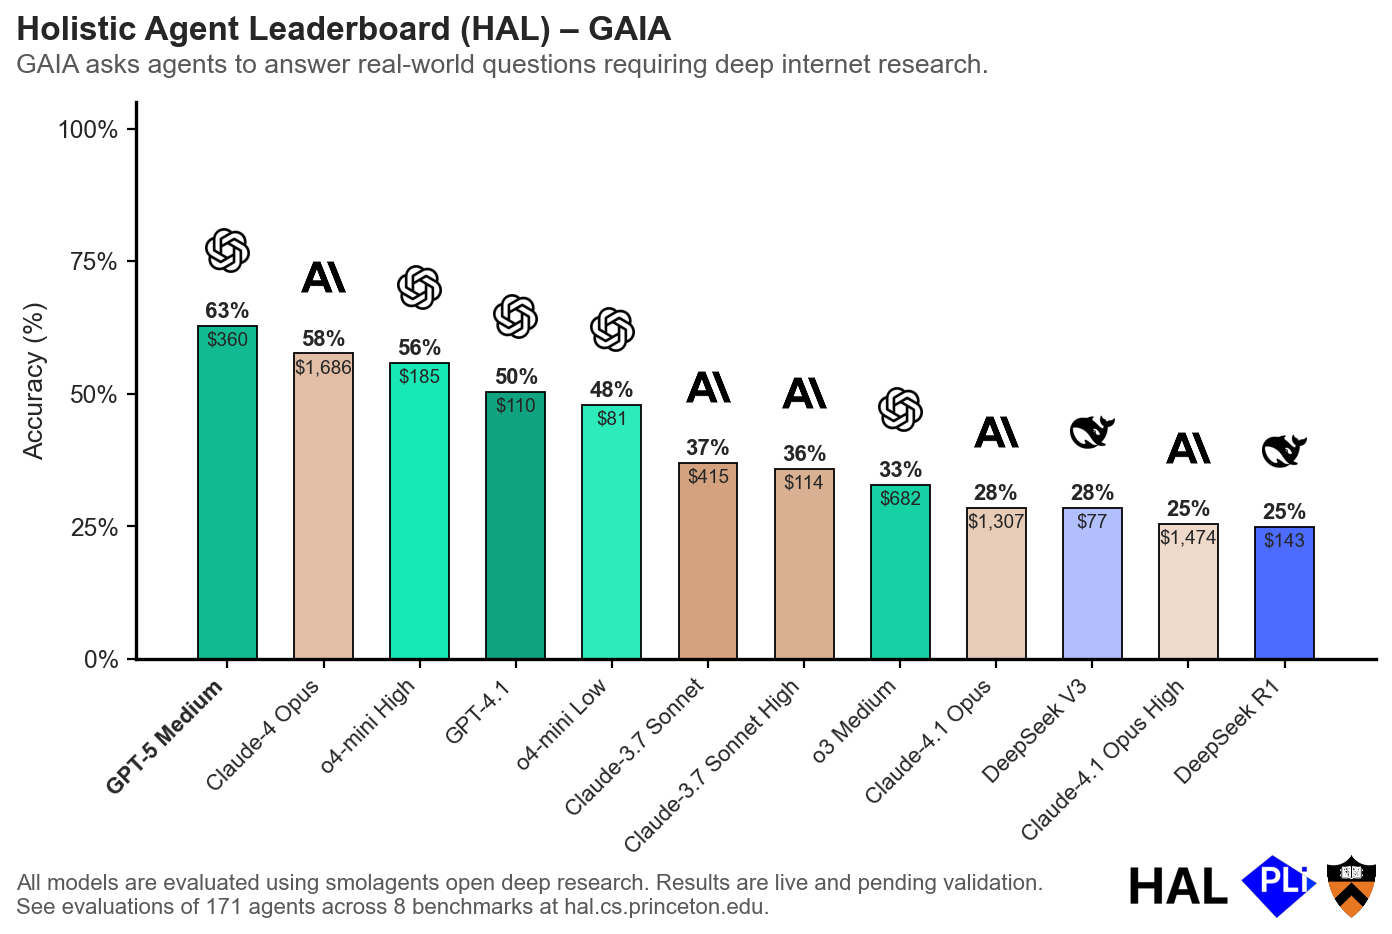

Saved plot: hal_gaia.png

Creating plot for: Online Mind2Web


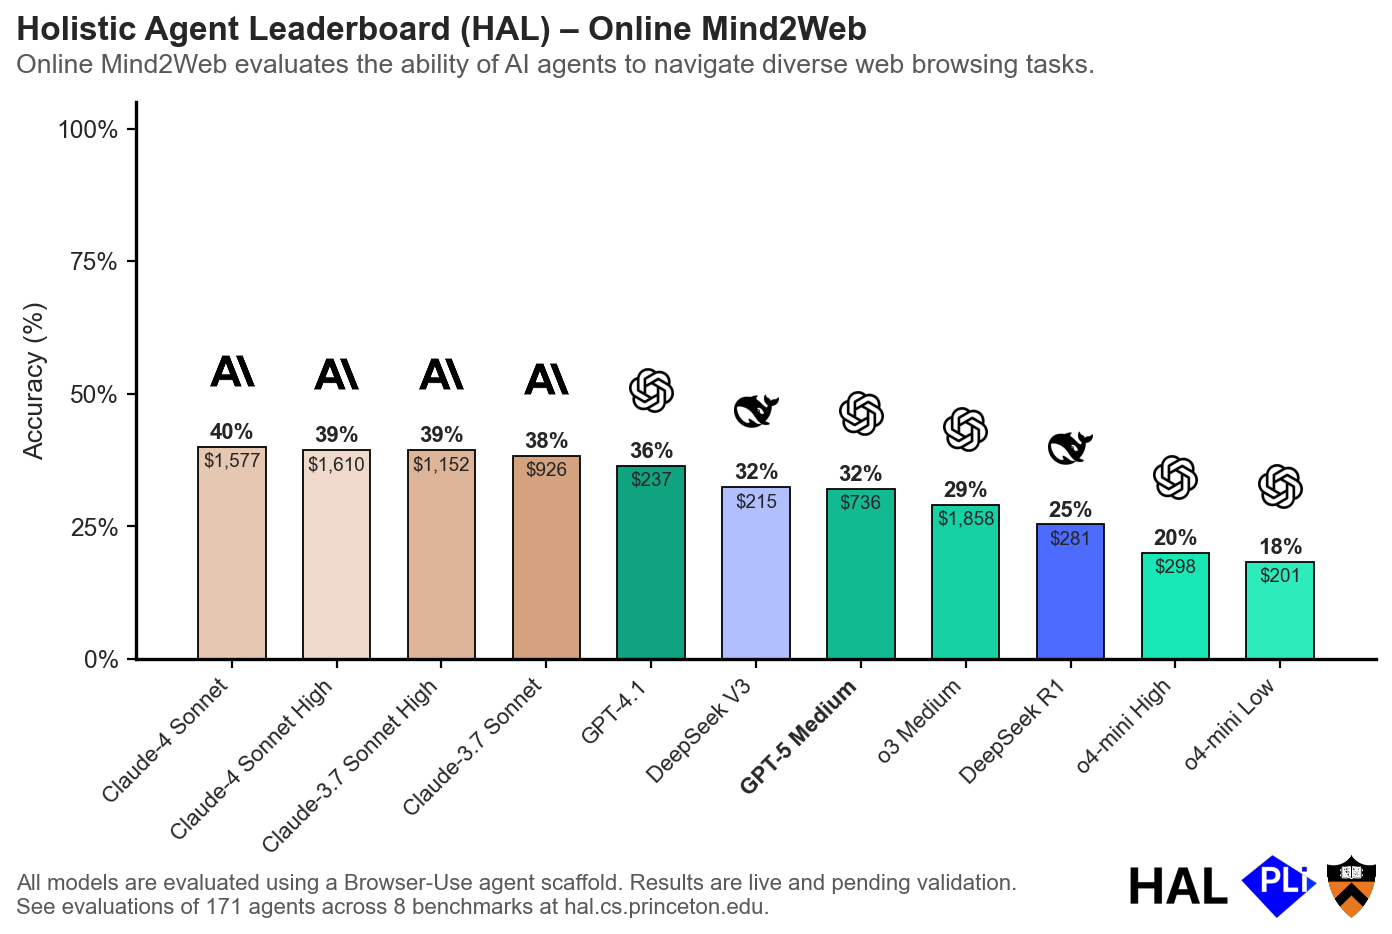

Saved plot: hal_online_mind2web.png


In [32]:
# Generate all plots
for benchmark_name in BENCHMARK_CONFIGS.keys():
    print(f"\n{'='*60}")
    print(f"Creating plot for: {benchmark_name}")
    print(f"{'='*60}")
    try:
        create_benchmark_plot(benchmark_name, most_recent_df, save_plots=True)
    except Exception as e:
        print(f"Error creating plot for {benchmark_name}: {e}")

## Multibenchmark Plot

Use the cell below to generate a single plot that combines multiple benchmarks

Creating faceted plot with models: ['Claude-4.1 Opus', 'Claude-4.1 Opus High', 'GPT-5 Medium', 'o3 Medium', 'Claude-4 Sonnet', 'Claude-4 Sonnet High']


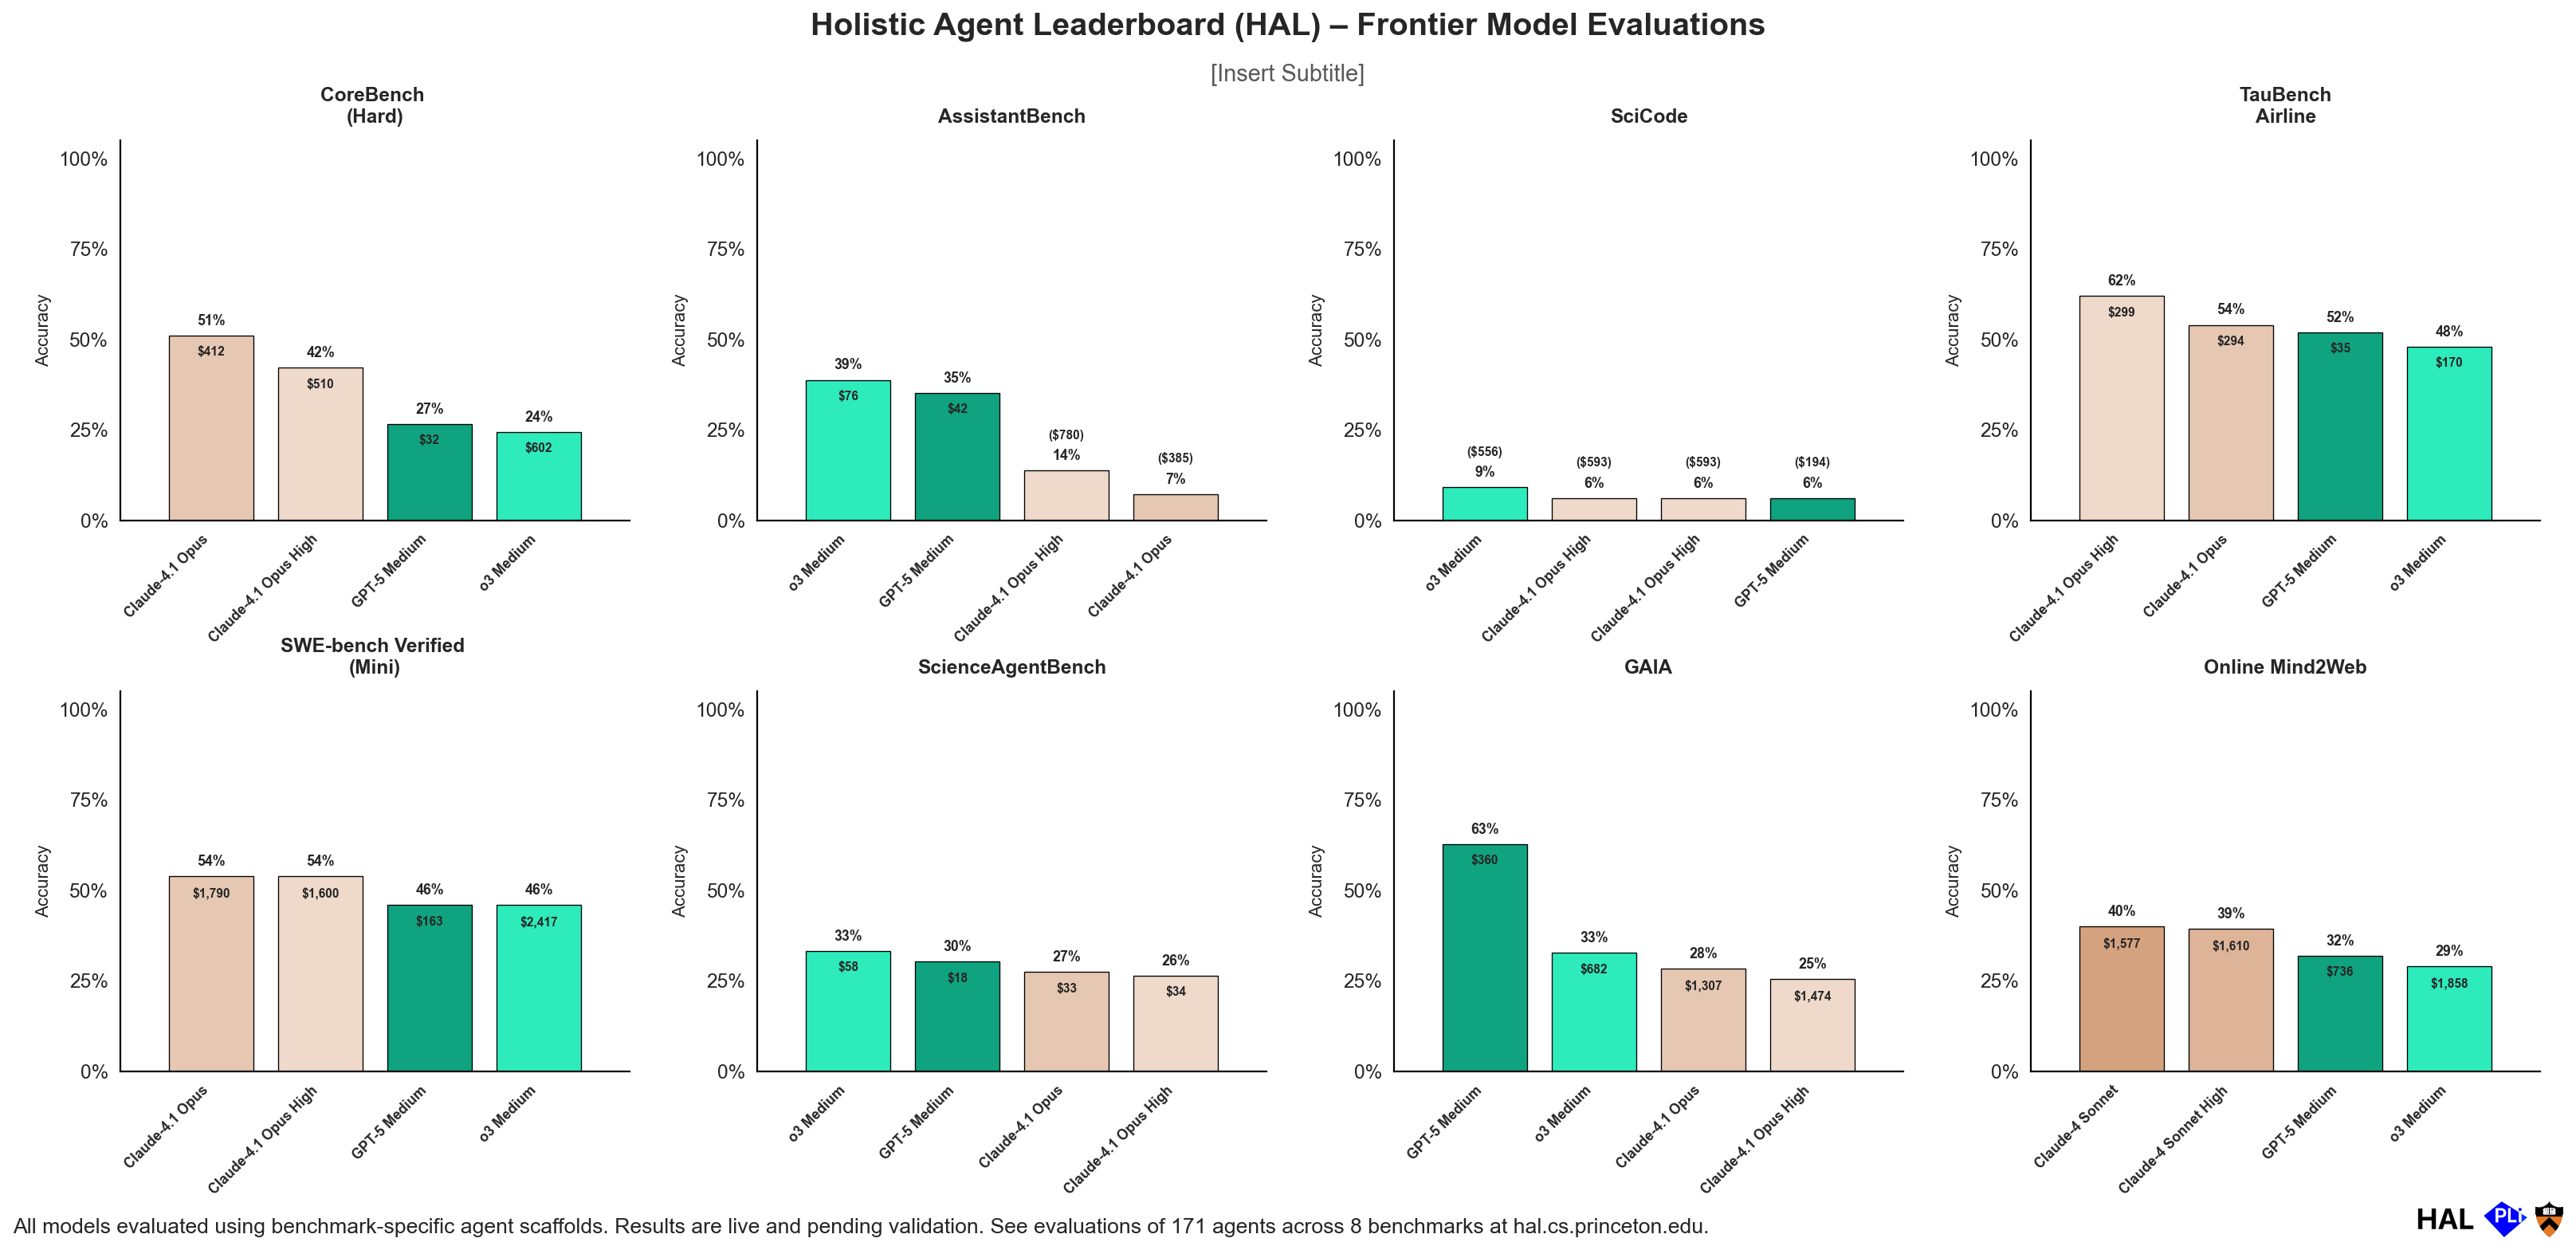

Saved plot: hal_multi_benchmark_comparison.png


In [37]:
def create_multi_benchmark_plot(data_df, selected_models=None, save_plots=True):
    """
    Create a faceted plot showing all benchmarks with selected models.
    
    Args:
        data_df: The dataframe containing benchmark data
        selected_models: List of model names to include. If None, uses default set.
        save_plots: Whether to save the plot to disk
    """
    
    # Default model selection - edit this list as needed
    if selected_models is None:
        selected_models = [
            "Claude-4.1 Opus",
            "Claude-4.1 Opus High",
            "GPT-5 Medium", 
            "o3 Medium",
            "Claude-4 Sonnet",
            "Claude-4 Sonnet High"
        ]
    
    print(f"Creating faceted plot with models: {selected_models}")
    
    # Set up the plot style
    mpl.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "font.size": 9,
        "hatch.linewidth": .8,
    })
    sns.set_theme(style="white", rc={"axes.grid": False})
    
    # Set up colors for selected models
    shade_of = setup_colors(selected_models)
    
    # Create figure with subplots arranged in 2 rows, 4 columns
    benchmarks = list(BENCHMARK_CONFIGS.keys())
    n_benchmarks = len(benchmarks)
    ncols = 4
    nrows = 2
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
    axes = axes.flatten()  # Make it easier to iterate
    
    # Plot each benchmark
    for idx, benchmark_name in enumerate(benchmarks):
        ax = axes[idx]
        config = BENCHMARK_CONFIGS[benchmark_name]
        
        try:
            # Prepare data for this benchmark
            plot_data = prepare_plot_data(benchmark_name, config, data_df)
            
            # Filter to only selected models that exist in this benchmark
            plot_data = plot_data[plot_data['model'].isin(selected_models)]
            
            if plot_data.empty:
                ax.text(0.5, 0.5, f'No data for\n{benchmark_name}', 
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=10, color='gray')
                ax.set_title(benchmark_name.replace(' – ', '\n'), fontsize=11, fontweight='bold', pad=10)
                continue
            
            # Sort models by accuracy for this benchmark
            models_for_benchmark = (plot_data.sort_values('accuracy', ascending=False)['model'].tolist())
            
            # Set up bar positions
            inner_gap = 0.05
            group_w = 0.85
            n_models = len(models_for_benchmark)
            bar_w = (group_w - (n_models-1)*inner_gap) / n_models
            offsets = (np.arange(n_models) - (n_models-1)/2) * (bar_w + inner_gap)
            
            # Plot bars
            for off, model in zip(offsets, models_for_benchmark):
                row_data = plot_data[plot_data['model'] == model].iloc[0]
                accuracy = row_data['accuracy']
                cost = row_data['total_cost']
                
                # Draw bar
                ax.bar(off, accuracy, width=bar_w, 
                      color=shade_of[model], edgecolor='black', linewidth=0.6)
                
                # Add accuracy label
                ax.text(off, accuracy + 0.02, f"{accuracy:.0%}", 
                       ha='center', va='bottom', fontsize=8, weight='bold')
                
                # Add cost label (smaller, inside bar if space allows)
                if accuracy > 0.15:
                    ax.text(off, accuracy - 0.03, f"${cost:,.0f}", 
                           ha='center', va='top', fontsize=7, weight='bold')
                else:
                    ax.text(off, accuracy + 0.08, f"(${cost:,.0f})", 
                           ha='center', va='bottom', fontsize=7, weight='bold')
            
            # Style this subplot
            ax.set_xticks(offsets)
            ax.set_xticklabels(models_for_benchmark, rotation=45, ha='right', fontsize=8)
            ax.set_ylim(0, 1.05)
            ax.set_xlim(offsets.min()-bar_w/2-0.1, offsets.max()+bar_w/2+0.1)
            ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
            ax.yaxis.set_major_locator(MultipleLocator(0.25))
            
            # Clean up spines
            sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
            for spine in ('left', 'bottom'):
                ax.spines[spine].set_visible(True)
                ax.spines[spine].set_linewidth(1)
                ax.spines[spine].set_color('black')
            
            ax.tick_params(axis='both', which='major', color='black', width=0.8, length=3)
            ax.set_ylabel("Accuracy", fontsize=10)
            
            # Set title (split long benchmark names)
            title = benchmark_name.replace(' – ', '\n').replace('(', '\n(')
            ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
            
            # Bold GPT-5 Medium labels
            for lbl in ax.get_xticklabels():
                if lbl.get_text() != "nan":
                    lbl.set_fontweight('bold')
                    
        except Exception as e:
            print(f"Error plotting {benchmark_name}: {e}")
            ax.text(0.5, 0.5, f'Error:\n{benchmark_name}', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=10, color='red')
            ax.set_title(benchmark_name, fontsize=11, fontweight='bold', pad=10)
    
    # Hide any unused subplots
    for idx in range(n_benchmarks, len(axes)):
        axes[idx].set_visible(False)
    
    # Add overall title and subtitle
    fig.suptitle("Holistic Agent Leaderboard (HAL) – Frontier Model Evaluations", 
                fontsize=18, fontweight='bold', y=0.98)
    fig.text(0.5, 0.94, "[Insert Subtitle]", 
            ha='center', va='top', fontsize=13, color='.35')
    
    # Add footer
    footer_text = ("All models evaluated using benchmark-specific agent scaffolds. Results are live and pending validation. "
                  "See evaluations of 171 agents across 8 benchmarks at hal.cs.princeton.edu.")
    fig.text(0.0, 0.02, footer_text, ha='left', va='bottom',
             fontsize=12)
    
    # Add footer logos
    footer_logo_paths = [
        str(quantitative_dir / "assets/HAL.png"),
        str(quantitative_dir / "hal-frontend/static/pli.png"),
        str(quantitative_dir / "hal-frontend/static/princeton.png"),
    ]
    
    icons = []
    for p in footer_logo_paths:
        if os.path.exists(p):
            img = mpimg.imread(p)
            zoom = 20 / img.shape[0]  # 20px height
            icons.append(OffsetImage(img, zoom=zoom, resample=True))
    
    if icons:
        fig.add_artist(AnchoredOffsetbox(
            loc='lower right',
            child=HPacker(children=icons, align='center', pad=0, sep=5),
            frameon=False, pad=0.02,
            bbox_to_anchor=(1, 0.02),
            bbox_transform=fig.transFigure, borderpad=0
        ))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.15, hspace=0.45, wspace=0.25)
    plt.show()
    
    # Save plot
    if save_plots:
        output_path = str(quantitative_dir / "plots/")
        output_filename = "hal_multi_benchmark_comparison.png"
        fig.savefig(os.path.join(output_path, output_filename), bbox_inches='tight', dpi=400)
        print(f"Saved plot: {output_filename}")

# Create the multi-benchmark plot
create_multi_benchmark_plot(most_recent_df, save_plots=True)